# Goal

This notebook generates the figures for the paper.

Figure 1(a): dset files
Figure 1(b): model input, binary seg output, crop
Figure 2(a): workflow
Figure 2(b): strategies

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [7]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
%load_ext autoreload
%autoreload 2

import os, shutil, time
from pathlib import Path

from monai.losses import DiceLoss

import matplotlib.pyplot as plt
import numpy as np
import torch
import SimpleITK as sitk

from helpers.items_constants import *
from helpers.transforms_simplified import *
from helpers.general import rm_prefix, get_param_default, modelfn2dict, torch2sitk, sitk2torch
from helpers.model_loss_choices import get_model, get_loss
from helpers.preprocess import batch_get_bbox
from helpers.postprocess import get_largest_connected_component, eval_measure, eval_lcc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# INFERENCE DATALOADER PARAMS
num_workers = 2

In [10]:
# Items as dict 
items  = all_test_lbl_items
itemsd = getd(items)

print(f"n = {len(itemsd)}, test items = {len(test_items)}, other dsets = {len(cross_lbl_items)}")
print(f"first item", itemsd[0])

# Transforms

# for condseg
train_itemsd = getd(train_items) # for condseg atlas choice

val_tfm_dict = {}
for condseg_bool in (True, False):
    for full_res,pixdim in ((96,1.5),(144,1.0)):
        val_tfm_dict[f"full_res_{full_res}_pixdim_{pixdim}_do_condseg_{condseg_bool}"] = \
            get_train_valid_transforms(items=train_itemsd, pixdim=pixdim, full_res=full_res, do_condseg=condseg_bool)[1]


# Models to Ensemble
# models_to_ensemble = [
#     # UNET DICE, VNET DICE, UNET BCE, VNET BCE, OBELISK DICE, OBELISK BCE, CONDSEG DICE, CONDSEG BCE
#     "model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18",
#     "model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08",
#     "model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18",
#     "model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10",
#     "model_OBELISKHYBRID_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963440_Tue_Aug_03_2021_hr_00_min_04",
#     "model_OBELISKHYBRID_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963631_Tue_Aug_03_2021_hr_00_min_07",
# #     "model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097973_Wed_Aug_04_2021_hr_13_min_26",
# #     "model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26"
# ]

models_to_ensemble = [
    # UNET DICE, VNET DICE, UNET BCE, VNET BCE, OBELISK DICE, OBELISK BCE, CONDSEG DICE, CONDSEG BCE
    "model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18",
    "model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08",
    "model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18",
    "model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10",
#    "model_OBELISKHYBRID_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963440_Tue_Aug_03_2021_hr_00_min_04",
#    "model_OBELISKHYBRID_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963631_Tue_Aug_03_2021_hr_00_min_07",
     "model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097973_Wed_Aug_04_2021_hr_13_min_26",
     "model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26"
]

n = 484, test items = 66, other dsets = 418
first item {'image': '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50011/MP-RAGE/2000-01-01_00_00_00.0/S165075/ABIDE_50011_MRI_MP-RAGE_br_raw_20120830203207657_S165075_I329085_corrected_n4.nii', 'label': '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50011/seg.nii'}


# Get preds from each model

In [12]:
# inputs, labels. Check that the order matches.

# create batches
bs        = 5
batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]
ranges  = [range(i,min(i+bs, len(itemsd))) for i in range(0,len(itemsd),bs)]

# get inputs, labels of first 5
full_res = tuple(96 for _ in range(3)) # 144
pixdim   = tuple(1.5 for _ in range(3))
do_condseg = False

#load labels
val_str = f"full_res_{full_res[0]}_pixdim_{pixdim[0]}_do_condseg_{do_condseg}"
transformed_labels_src = f"{data_src}/saved_transformed_labels/{val_str}"

def is_obelisk_144(fn):
    return "OBELISK" in str(fn) and "full_res_144_pixdim_1.0" in str(fn)

i = 0
    
# get stored inputs, labels
with open(f"{transformed_labels_src}/transformed_labels_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
    data = pickle.load(handle)

inputs, labels = zip(*data) # [(img,lbl), (img,lbl)] => imgs, labels
inputs = torch.stack(inputs, dim=0)
labels = torch.stack(labels, dim=0)
inputs = inputs.to(device)
print("inputs", inputs.shape, "labels", labels.shape, len(labels))

# choose fn
stored_preds_all = []
for fn in models_to_ensemble:
    print("*"*50); print(fn)

    # get stored predictions
    model_name = Path(fn).name

    start_src = f"{run_src}/{model_name}/to_96_" if is_obelisk_144(fn) else f"{run_src}/{model_name}/"
    with open(f"{start_src}preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
        stored_preds = pickle.load(handle)
        
    # to tensor
    if is_obelisk_144(fn):
        stored_preds = [torch.tensor(pred) for pred in stored_preds]

    stored_preds_all.append(stored_preds)
    
    # recalculate preds
    _, stored_preds_post_metrics = zip(*[eval_lcc(labels[i], stored_preds[i])
                                          for i in range(bs)
                                         ])

    recalc_dices = [d["dice"] for d in stored_preds_post_metrics]
    print(fn, recalc_dices)
#val_str = "full_res_144_pixdim_1.0_do_condseg_False"
#val_str = "full_res_96_pixdim_1.5_do_condseg_False"

inputs torch.Size([5, 1, 96, 96, 96]) labels torch.Size([5, 1, 96, 96, 96]) 5
**************************************************
model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18
model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18 [0.8657099628627757, 0.8420114122681882, 0.866526093832367, 0.7315091408770463, 0.7100601818259423]
**************************************************
model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08
model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08 [0.8620303133680979, 0.8585049813581077, 0.8869594443199641, 0.7379516308485097, 0.7068950966326273]
**************************************************
model_UNET3D_los

# Get ensemble model

In [15]:
import re

# create batches
bs        = 5
batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]

def get_model_id(model_fn):
    """ model ids = time string """
    return re.search("(time_\d+)", model_fn).groups(0)[0]

ensemble_name = "_and_".join([get_model_id(model_fn) for model_fn in models_to_ensemble])
print(ensemble_name)

# mkdir
ensemble_src = f"{run_src}/model_ensemble/{ensemble_name}"
print("ensemble_src", ensemble_src)
Path(ensemble_src).mkdir(parents=True, exist_ok=True)

if not os.path.isfile(f"{ensemble_src}/models_to_ensemble.pkl"):
    with open(f"{ensemble_src}/models_to_ensemble.pkl", 'wb') as handle:
            pickle.dump(models_to_ensemble, handle)

time_1627971508_and_time_1627978137_and_time_1627971506_and_time_1627978233_and_time_1628097973_and_time_1628097978
ensemble_src /gpfs/data/oermannlab/private_data/DeepPit/runs/model_ensemble/time_1627971508_and_time_1627978137_and_time_1627971506_and_time_1627978233_and_time_1628097973_and_time_1628097978


# Load ensemble segmentation

In [17]:
# load ensemble

ensemble_name          = "_and_".join([get_model_id(model_fn) for model_fn in models_to_ensemble])
ensemble_src           = f"{run_src}/model_ensemble/{ensemble_name}"

print(ensemble_name)

# Items as dict 
items  = all_test_lbl_items
itemsd = getd(items)

# create batches
bs        = 5
batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]

# load preds
ensemble_all_majority_vote = []
ensemble_bce_majority_vote = []
ensemble_dice_majority_vote = []

start = time.time()
for i in range(len(batches)):
    with open(f"{ensemble_src}/dice_preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
        ensemble_dice_majority_vote += pickle.load(handle)

    with open(f"{ensemble_src}/bce_preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
        ensemble_bce_majority_vote += pickle.load(handle)

    with open(f"{ensemble_src}/all_preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
        ensemble_all_majority_vote += pickle.load(handle)
        
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s")

time_1627971508_and_time_1627978137_and_time_1627971506_and_time_1627978233_and_time_1628097973_and_time_1628097978
Elapsed: 2.43 s


In [18]:
# print("all data = inputs/labels", len(all_data))
print("dice majority vote", len(ensemble_dice_majority_vote), 
      "bce majority vote", len(ensemble_bce_majority_vote), 
      "all majority vote", len(ensemble_all_majority_vote), sep="\n")

dice majority vote
484
bce majority vote
484
all majority vote
484


In [19]:
# read ensemble df    
ensemble_all_df = pd.read_pickle(f"{ensemble_src}/ensemble_all_df.pkl")
ensemble_dice_df = pd.read_pickle(f"{ensemble_src}/ensemble_dice_df.pkl")
ensemble_bce_df = pd.read_pickle(f"{ensemble_src}/ensemble_bce_df.pkl")

display(ensemble_all_df.head())

,dice,false_neg,false_pos,IoU,hausdorff_dist,image,label
0,0.770689,0.309877,0.127449,0.626927,4.123106,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50011/MP-RAGE/2000-01-01_00_00_00.0/S165075/ABIDE_50011_MRI_MP-RAGE_br_raw_20120830203207657_S165075_I329085_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50011/seg.nii
1,0.158262,0.859278,0.819204,0.085931,14.696938,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50379/MP-RAGE/2000-01-01_00_00_00.0/S165402/ABIDE_50379_MRI_MP-RAGE_br_raw_20120830233630136_S165402_I329412_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50379/seg.nii
2,0.445787,0.575537,0.530633,0.286825,11.045361,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50008/MP-RAGE/2000-01-01_00_00_00.0/S164971/ABIDE_50008_MRI_MP-RAGE_br_raw_20120830194128385_S164971_I328981_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50008/seg.nii
3,0.272053,0.782490,0.636892,0.157443,14.628739,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50333/MP-RAGE/2000-01-01_00_00_00.0/S165330/ABIDE_50333_MRI_MP-RAGE_br_raw_20120830225747452_S165330_I329340_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50333/seg.nii
4,0.635359,0.512664,0.087469,0.465587,10.954451,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50060/MP-RAGE/2000-01-01_00_00_00.0/S164445/ABIDE_50060_MRI_MP-RAGE_br_raw_20120830160721935_S164445_I328442_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50060/seg.nii


# Get original MR

In [24]:
idx = 4
item = itemsd[idx]

item {'image': '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50060/MP-RAGE/2000-01-01_00_00_00.0/S164445/ABIDE_50060_MRI_MP-RAGE_br_raw_20120830160721935_S164445_I328442_corrected_n4.nii', 'label': '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50060/seg.nii'}
original bbox tensor([ 75, 106, 134, 163, 104, 127])
original shape torch.Size([176, 256, 256])
Middle of axis 0 of orig bbox:  tensor(90)


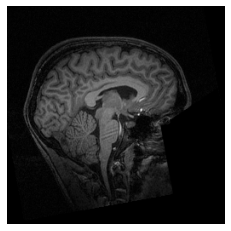

In [25]:
# Get original MR
from monai.transforms import LoadImaged, ToTensord
from helpers.transforms_simplified import UndoDict
from helpers.viz import get_mid_idx

keys=["image","label"]

orig_input = ToTensord(keys)(LoadImaged(keys)(item))
orig_mr, orig_mk = UndoDict()(orig_input)
orig_bbox = batch_get_bbox(orig_mk.unsqueeze(0))[0]
orig_mid0 = get_mid_idx(orig_bbox)[0]

print("item", item)                             
print("original bbox", orig_bbox)
print("original shape", orig_mr.shape)
print("Middle of axis 0 of orig bbox: ", orig_mid0)
# seg_dict = {"image": orig_mr, "label": orig_seg}
# val_transforms[:,-1].inverse(seg_dict)

# print(orig_input.shape)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(np.rot90(orig_mr[orig_mid0]), cmap=plt.cm.gray)
fig.savefig(f"model_orig_inputs_{Path(item['image']).name}.png", bbox_inches='tight', dpi = 1000)


In [26]:
f"model_orig_inputs_{Path(item['image']).name}.png"

'model_orig_inputs_ABIDE_50060_MRI_MP-RAGE_br_raw_20120830160721935_S164445_I328442_corrected_n4.nii.png'

In [27]:
from helpers.transforms_simplified import fake_tfms

In [29]:
# test Pipeline

# standard: 96 full res, pixdim 1.5
# full_res = tuple(96 for _ in range(3)) # 144
# pixdim   = tuple(1.5 for _ in range(3))
# do_condseg = False

train_itemsd = getd(train_items) # for condseg atlas choice

val_tfm_dict = {}
for condseg_bool in (True, False):
    for full_res,pixdim in ((96,1.5),(144,1.0)):
        val_tfm_dict[f"full_res_{full_res}_pixdim_{pixdim}_do_condseg_{condseg_bool}"] = \
            get_train_valid_transforms(items=train_itemsd, pixdim=pixdim, full_res=full_res, do_condseg=condseg_bool)[1]
        
val_tfms = val_tfm_dict["full_res_96_pixdim_1.5_do_condseg_False"]        

In [30]:
# Trace orig mr idx
from monai.transforms import LoadImage, Compose

# fake_tfms_todo = fake_tfms(key="label", pixdim=(1.5,1.5,1.5), full_res=(96, 96, 96))
# fake_output =fake_tfms_todo(fake_input)

# remove load image (tfm 0), intensity normalize (tfm 2)
spatial_tfms = (val_tfms.transforms[1], *val_tfms.transforms[3:])
print(*spatial_tfms, sep="\n")

# add id to middle of each slice
fake = torch.zeros(orig_mr.shape)
fake_mid = np.asarray(orig_mr.shape)[1:]//2
for i in range(orig_mr.shape[0]):
    #fake[i,fake_mid[0], fake_mid[1]] = i
    fake[i,fake_mid[0]-20:fake_mid[0]+20, fake_mid[1]-20:fake_mid[1]+20] = i
    
fake_input = LoadImaged(keys)(item)
fake_input["image"] = fake
fake_input["label"] = fake

# remove mk's ch dim from (mr, mk) after, shape = full_res
fake_output = Compose(spatial_tfms)(fake_input)
fake_output = fake_output[1].squeeze(0)

UndoDict(['image', 'label'])


In [31]:
# 6 segmentation masks
preds = [get_largest_connected_component(torch2sitk(preds[idx].argmax(0).byte())) for preds in stored_preds_all]
pred_bboxs = batch_get_bbox(torch.stack([sitk2torch(pred).byte() for pred in preds], dim=0))

In [33]:
print("orig mr mid0", orig_mid0)
print((fake_output==orig_mid0).nonzero())

# index 47
input_mid0 = 50

print(fake_output[input_mid0,40:50,40:50])

orig mr mid0 tensor(90)
tensor([[50, 34, 27],
        [50, 34, 28],
        [50, 34, 29],
        ...,
        [50, 61, 66],
        [50, 61, 67],
        [50, 61, 68]])
tensor([[90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.],
        [90., 90., 90., 90., 90., 90., 90., 90., 90., 90.]])


In [34]:
print(*pred_bboxs, sep="\n")

tensor([34, 66, 50, 71, 28, 50])
tensor([36, 66, 51, 70, 27, 50])
tensor([34, 66, 51, 71, 25, 50])
tensor([36, 66, 52, 69, 26, 49])
tensor([33, 67, 51, 71, 26, 51])
tensor([34, 66, 51, 71, 26, 50])


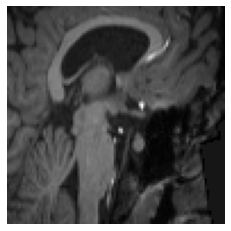

In [35]:
# input
fig, ax = plt.subplots()
ax.axis('off')

# BC, DHW
ax.imshow(np.rot90(inputs[0,0][input_mid0]), cmap=plt.cm.gray)
fig.savefig(f"model_input.png", bbox_inches='tight', dpi = 1000)

In [36]:
pred_bboxs

tensor([[34, 66, 50, 71, 28, 50],
        [36, 66, 51, 70, 27, 50],
        [34, 66, 51, 71, 25, 50],
        [36, 66, 52, 69, 26, 49],
        [33, 67, 51, 71, 26, 51],
        [34, 66, 51, 71, 26, 50]])

In [37]:
sitk2torch(preds[0]).shape

torch.Size([96, 96, 96])

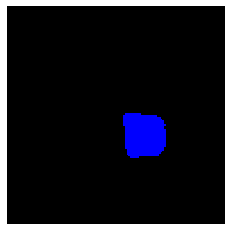

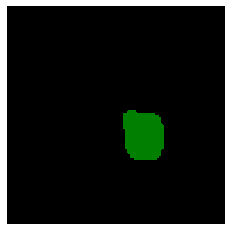

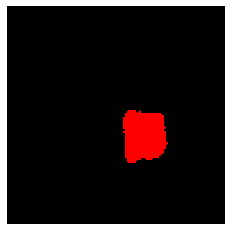

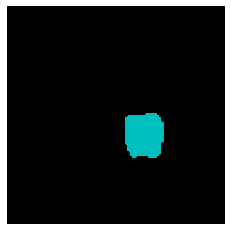

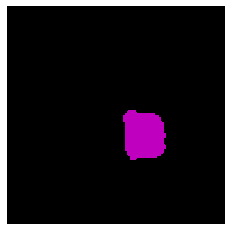

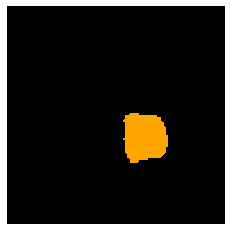

In [38]:
# input

from matplotlib import colors

color_list = ['b', 'g', 'r', 'c', 'm', 'orange']
bin_cmaps  = {color:colors.ListedColormap(['black', color]) for color in color_list}


# BC, DHW
for i, color in enumerate(color_list):
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(np.rot90(sitk2torch(preds[i])[input_mid0]), cmap=bin_cmaps[color])
    fig.savefig(f"model_output_{i}.png", bbox_inches='tight', dpi = 1000)

In [39]:
# get majority vote

# 6 preds for given label ==> max dice pre, ensemble dice
def get_majority_vote(label, preds_lcc): # all_preds
    #label      = torch2sitk(label.squeeze(0).byte())
    #preds_lcc  = [get_largest_connected_component(torch2sitk(pred.argmax(0).byte())) for pred in all_preds]
        
    labelForUndecidedPixels = 0
    majority_vote = sitk.LabelVoting(preds_lcc, labelForUndecidedPixels)
        
    # get metrics
    majority_metrics = eval_measure(label, majority_vote)
    indiv_metrics = [eval_measure(label, pred_lcc) for pred_lcc in preds_lcc]
    
    return sitk2torch(majority_vote), [sitk2torch(pred_lcc) for pred_lcc in preds_lcc], majority_metrics, indiv_metrics

In [40]:
labelForUndecidedPixels = 0
majority_vote = sitk.LabelVoting(preds, labelForUndecidedPixels)

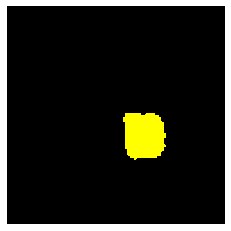

In [41]:
from helpers.general import sitk2np
yellow_cmap = colors.ListedColormap(['black', 'yellow'])
                                          
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(np.rot90(sitk2np(majority_vote)[input_mid0]), cmap=yellow_cmap)
fig.savefig(f"model_output_majority.png", bbox_inches='tight', dpi = 1000)

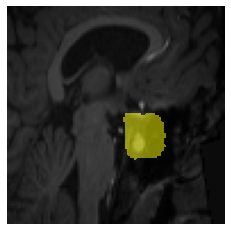

In [42]:
# final overlay
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(np.rot90(inputs[0,0][input_mid0]),cmap=plt.cm.gray)
ax.imshow(np.rot90(sitk2np(majority_vote)[input_mid0]),cmap=yellow_cmap, alpha=0.5)
fig.savefig(f"model_overlay.png", bbox_inches='tight', dpi = 1000)

51 69 28 48
im (96, 96) sg (96, 96) (96, 96) (18, 20)
Resampled by a factor of 2 with cubic interpolation:


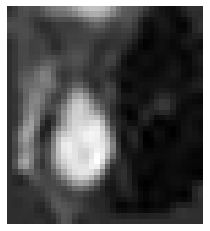

In [43]:
def twod_get_bbox(masks):
    # HW -> H
    # HW -> W
    j = torch.any(masks, dim=0) # 0 -> 1,2 -> 2 -> 1 left
    i = torch.any(masks, dim=1) # 1 -> 0,2 -> 0 -> 0 left

    imin, imax = torch.where(i)[0][[0, -1]]
    jmin, jmax = torch.where(j)[0][[0, -1]]
  
    return imin,imax,jmin,jmax

im = inputs[0,0][input_mid0]
sg = sitk2torch(majority_vote)[input_mid0]
a,b,c,d = np.asarray(twod_get_bbox(sg))
print(a,b,c,d)

im = np.asarray(im)
sg = np.asarray(sg)
m = np.multiply(im,sg)
print("im", im.shape, "sg", sg.shape, (im*sg).shape, np.multiply(im,sg)[a:b,c:d].shape)

import scipy.ndimage

x = m[a:b,c:d]
print('Resampled by a factor of 2 with cubic interpolation:')
fig, ax = plt.subplots(1,1)
ax.axis('off')
ax.imshow(np.rot90(scipy.ndimage.zoom(x, 2, order=5)), cmap=plt.cm.gray)
fig.savefig(f"model_cropped_Viz.png", bbox_inches='tight', dpi = 1000)

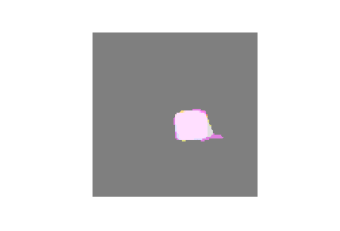

In [100]:
# ADDITIVE BLENDING: https://stackoverflow.com/questions/26702176/is-it-possible-to-do-additive-blending-with-matplotlib

# input

from matplotlib import colors

color_list = ['b', 'g', 'r', 'c', 'm', 'y']
bin_cmaps  = {color:colors.ListedColormap(['black', color]) for color in color_list}

fig, ax = plt.subplots(1,1)
w, h = fig.canvas.get_width_height()
ax.axis('off')

# draw seg masks
# BC, DHW
imgs = []
for i, color in enumerate(color_list):
    ax.clear()
    ax.axis('off')
    ax.imshow(np.rot90(sitk2torch(preds[i])[input_mid0]), cmap=bin_cmaps[color], alpha=0.5)
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).reshape(h, w, -1).copy()
    imgs.append(img)

    
for img in imgs:
    img[img[:, :, -1] == 0] = 0

fig.clf()

plt.imshow(np.maximum.reduce(imgs))
plt.axis("off")
plt.show()

#fig.savefig(f"model_input.png", bbox_inches='tight', dpi = 1000)

In [94]:
np.maximum(imgs)

ValueError: invalid number of arguments

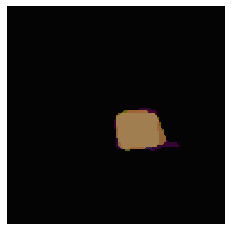

In [85]:
# input

from matplotlib import colors

color_list = ['b', 'g', 'r', 'c', 'm', 'y']
bin_cmaps  = {color:colors.ListedColormap(['black', color]) for color in color_list}

fig, ax = plt.subplots()
ax.axis('off')
    
# BC, DHW
for i, color in enumerate(color_list):
    ax.imshow(np.rot90(sitk2torch(preds[i])[input_mid0]), cmap=bin_cmaps[color], alpha=0.5)
#fig.savefig(f"model_input.png", bbox_inches='tight', dpi = 1000)

In [36]:
for model_fn in models_to_ensemble:
    
pre_metrics, post_metrics = zip(*[eval_lcc(labels[i], outputs[i])
                                      for i in range(len(labels))
                                     ])

IndentationError: expected an indented block (<ipython-input-36-bda2080747da>, line 2)

In [ ]:
from monai.losses import DiceLoss

dice_loss = DiceLoss(
    include_background=False, 
    to_onehot_y=False, 
    sigmoid=False, 
    softmax=False, 
    other_act=None, 
    squared_pred=False, 
    jaccard=False, 
    reduction="none", 
    smooth_nr=0, #1e-05, 
    smooth_dr=0, #1e-05, 
    batch=False)

start = time.time()

indiv_dices = dice_loss(predictions.argmax(1).unsqueeze(1), targets)
indiv_dices = [1-dice_loss for dice_loss in indiv_dices]

elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

# Transforms

In [28]:
from helpers.general import rm_prefix, get_param_default, modelfn2dict

models_to_ensemble = [
    # UNET DICE, VNET DICE, UNET BCE, VNET BCE, OBELISK DICE, OBELISK BCE, CONDSEG DICE, CONDSEG BCE
    "model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18",
    "model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08",
    "model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18",
    "model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10",
    "model_OBELISKHYBRID_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963440_Tue_Aug_03_2021_hr_00_min_04",
    "model_OBELISKHYBRID_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963631_Tue_Aug_03_2021_hr_00_min_07",
#     "model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097973_Wed_Aug_04_2021_hr_13_min_26",
#     "model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26"
]

# doing    
model_fn   = models_to_ensemble[0]
model_name = Path(model_fn).name

# get params
model_dict = modelfn2dict(model_fn)
model_type, loss_type, full_res, pixdim, do_flip, do_simple = \
        [model_dict[k] for k in ("model_type", "loss_type", "full_res", "pixdim", "do_flip", "do_simple")]

print(f"Chosen: {model_name}")


print(f"Model: {model_type}")
print(f"Loss : {loss_type}")
print(f"Pixd : {pixdim}")
print(f"Fullres : {full_res}")
print(f"Do flip: {do_flip}")
print(f"Do simple: {do_simple}")


# Transforms

from helpers.transforms_simplified import *
train_itemsd = getd(train_items) # for condseg atlas choice
print(f"{model_type}, {loss_type}, res {full_res} simple augs {do_simple} flip {do_flip} weird {not do_simple and not do_flip}")
_, val_tfms = get_train_valid_transforms(items=train_itemsd, pixdim=pixdim, full_res=full_res, 
                                              do_flip=do_flip, do_simple=do_simple, do_condseg=(model_type=="CONDSEG"))
print(f"val tfms: ", *val_tfms.transforms, sep="\n")


Chosen: model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18
Model: UNET3D
Loss : DICE_loss
Pixd : (1.5, 1.5, 1.5)
Fullres : (96, 96, 96)
Do flip: True
Do simple: True
UNET3D, DICE_loss, res (96, 96, 96) simple augs True flip True weird False
val tfms: 
UndoDict(['image', 'label'])


In [29]:
# from helpers.transforms import get_train_valid_transforms, monai_tfms2str

# full_res = (96,96,96)
# pixdim   = (1.5,1.5,1.5)
# train_tfms, val_tfms = get_train_valid_transforms(pixdim=pixdim,full_res=full_res)
# print(f"val tfms: ", *val_tfms.transforms, sep="\n")

# print(monai_tfms2str(train_tfms))
# print(monai_tfms2str(val_tfms))

# Model

In [30]:
models_to_ensemble = [
    # UNET DICE, VNET DICE, UNET BCE, VNET BCE, OBELISK DICE, OBELISK BCE, CONDSEG DICE, CONDSEG BCE
    "model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18",
    "model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08",
    "model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18",
    "model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10",
    "model_OBELISKHYBRID_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963440_Tue_Aug_03_2021_hr_00_min_04",
    "model_OBELISKHYBRID_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963631_Tue_Aug_03_2021_hr_00_min_07",
#     "model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097973_Wed_Aug_04_2021_hr_13_min_26",
#     "model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26"
]

# model_UNET3D_loss_BCE_loss_bs_1_epochs_60_time_1627647477_Fri_Jul_30_2021_hr_08_min_17

In [31]:
# model_names = {
#     "unet_bce": "model_UNET3D_loss_BCE_loss_bs_1_epochs_60_time_1627647477_Fri_Jul_30_2021_hr_08_min_17",
#     "obelisk_bce": "model_OBELISKHYBRID_loss_BCE_loss_bs_1_epochs_60_time_1627823459_Sun_Aug_01_2021_hr_09_min_10",
#     "vnet_bce": "model_VNET_loss_BCE_loss_bs_1_epochs_60_time_1627823149_Sun_Aug_01_2021_hr_09_min_05"
# }

# model_name = model_names["unet_bce"]

In [32]:
# model_fns = sorted(Path(run_src).iterdir(), key=os.path.getmtime, reverse=True)
# model_fns = [str(p) for p in model_fns]

# #model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_67_epochs_30_time_1626043621_Sun_Jul_07_2021_hr_18_min_47.pth"
# model_idx = 3
# model_name   = Path(model_fns[model_idx]).name
# print(f"Chosen: {model_name}")
# print(f"Prior: ", *[f"{idx}: {model_fn[len(run_src):]}" for idx,model_fn in enumerate(model_fns[:5])], sep="\n")

In [33]:
from helpers.general            import get_param
from helpers.model_loss_choices import get_model, get_loss

model   = get_model(model_type, full_res)
loss_fn = get_loss(loss_type) 

In [34]:
# print
print("Model name: ", model_name)
print(f"Model type: {model_type}. Loss type: {loss_type}.")

Model name:  model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18
Model type: UNET3D. Loss type: DICE_loss.


# Learner

In [14]:
# Dataloaders

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *

#items  = all_test_lbl_items
items = all_test_lbl_items #ppmi, icmb, adni, aibl, abvib, test_items
itemsd = getd(items)

# time it - 18s for 484 items
start = time.time()

# create batches
bs        = 5
batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]

i     = 0
batch = batches[i]

data = Pipeline(val_tfms)(batch)
inputs, labels = zip(*data) # [(img,lbl), (img,lbl)] => imgs, labels
inputs = torch.stack(inputs, dim=0)
labels = torch.stack(labels, dim=0)
inputs = inputs.to(device)

with torch.no_grad():
    outputs = model(inputs).cpu()
        
# # tls, dls, cuda
# bs  = 2
# tls = TfmdLists(itemsd[:20], val_tfms)
# dls = tls.dataloaders(bs=bs, after_batch=[], num_workers=num_workers)
# dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed:.2f} s for {len(itemsd)} items")

import gc
gc.collect()

from helpers.losses import dice_score

learn = Learner(dls       = dls, 
                model     = model, 
                loss_func = loss_fn,
                metrics   = dice_score)

Elapsed time: 13.15 s for 484 items


In [15]:
# load model fname w/o .pth extension
learn.load(f"{run_src}/{model_name}/model")

# Figure 1b: model input, binary seg output, crop

In [16]:
# all predictions, 67 items, 4 workers, 15sec
# Elapsed: 326.07 s for 484 items.
start = time.time()
predictions, targets = learn.get_preds(dl=dls.train)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(itemsd)} items.")

Elapsed: 9.42 s for 484 items.


In [32]:
from monai.losses import DiceLoss

dice_loss = DiceLoss(
    include_background=False, 
    to_onehot_y=False, 
    sigmoid=False, 
    softmax=False, 
    other_act=None, 
    squared_pred=False, 
    jaccard=False, 
    reduction="none", 
    smooth_nr=0, #1e-05, 
    smooth_dr=0, #1e-05, 
    batch=False)

start = time.time()

indiv_dices = dice_loss(predictions.argmax(1).unsqueeze(1), targets)
indiv_dices = [1-dice_loss for dice_loss in indiv_dices]

elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

NameError: name 'predictions' is not defined

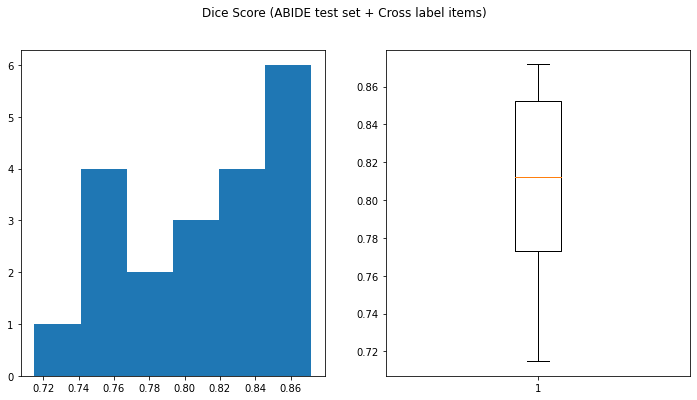

Elapsed: 0.26 s for 20 items.


In [18]:
start = time.time()

# sort dices from low to high
sorted_dice_idxs  = sorted(range(len(indiv_dices)), key=lambda i:indiv_dices[i].item()) 
np_indiv_dices = np.array([indiv_dices[i].item() for i in sorted_dice_idxs])

# plot
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0.hist(np_indiv_dices, bins="auto")
ax1.boxplot(np_indiv_dices)

fig1.suptitle("Dice Score (ABIDE test set + Cross label items)")
plt.show()

# time
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

In [20]:
from helpers.preprocess import batch_get_bbox

# Elapsed 65.148959 s
start = time.time()

# get masks and probs
pred_masks = torch.argmax(predictions, dim=1).byte()
pred_bboxs = batch_get_bbox(pred_masks)
gt_bboxs   = batch_get_bbox(targets)
#pred_probs = np.asarray(predictions.softmax(1)[:,1].cpu())

elapsed = time.time() - start
print(f"Elapsed {elapsed:2f} s")

Elapsed 2.714262 s


In [84]:
# Choose best of first 20

idx  = sorted_dice_idxs[-1]
pred_mk   = pred_masks[idx]
pred_bbox = pred_bboxs[idx]
item      = itemsd[idx]

print("Pred bbox", pred_bbox)
from helpers.viz import get_mid_idx

mid0 = get_mid_idx(pred_bbox)[0]
print("Middle of axis 0 of pred bbox: ", mid0)
# a,b,c,d,e,f = pred_bboxs[idx]
# mid0 = (a+b)//2
# mid1 = (c+d)//2
# mid2 = (e+f)//2
# print(mid0,mid1,mid2)

Pred bbox tensor([30, 66, 48, 71, 44, 62])
Middle of axis 0 of pred bbox:  tensor(48)


original bbox tensor([ 69, 103, 127, 158, 125, 148])
original shape torch.Size([172, 256, 256])
Middle of axis 0 of pred bbox:  tensor(48)
Middle of axis 0 of orig bbox:  tensor(86)


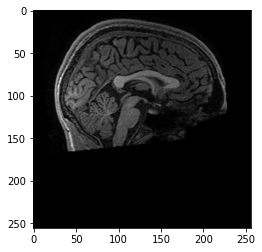

In [156]:
# Get original MR
from monai.transforms import LoadImaged, ToTensord
keys=["image","label"]

orig_input = ToTensord(keys)(LoadImaged(keys)(item))
orig_mr, orig_mk = UndoDict()(orig_input)
orig_bbox = batch_get_bbox(orig_mk.unsqueeze(0))[0]
orig_mid0 = get_mid_idx(orig_bbox)[0]
                             
print("original bbox", orig_bbox)
print("original shape", orig_mr.shape)
print("Middle of axis 0 of pred bbox: ", mid0)
print("Middle of axis 0 of orig bbox: ", orig_mid0)
# seg_dict = {"image": orig_mr, "label": orig_seg}
# val_transforms[:,-1].inverse(seg_dict)

# print(orig_input.shape)
plt.imshow(np.rot90(orig_mr[orig_mid0]), cmap=plt.cm.gray)

In [42]:
val_tfms.transforms

(<monai.transforms.io.dictionary.LoadImaged at 0x7f5f7004ed68>,
 UndoDict:
 encodes: (object,object) -> encodes
 decodes: )

In [47]:
from monai.data.image_reader import NibabelReader
reader = NibabelReader()

In [57]:
import SimpleITK as sitk
sitk_im = sitk.ReadImage(item["image"], sitk.sitkFloat32)
print(sitk_im.GetSpacing())

(1.0, 1.0, 1.0)


In [74]:
# # img = reader.read(item["image"])
# # img_array, meta_data = reader.get_data(img)
# # img_array = img_array.astype(np.float32)
# meta_data

In [94]:
val_tfms.transforms

(<monai.transforms.io.dictionary.LoadImaged at 0x7f5f7004ed68>,
 UndoDict:
 encodes: (object,object) -> encodes
 decodes: )

In [148]:
# Trace orig mr idx
from monai.transforms import LoadImage, Compose

# remove load image (tfm 0), intensity normalize (tfm 2)
spatial_tfms = (val_tfms.transforms[1], *val_tfms.transforms[3:])
print(*spatial_tfms, sep="\n")

# add id to middle of each slice
fake = torch.zeros(orig_mr.shape)
fake_mid = np.asarray(orig_mr.shape)[1:]//2
for i in range(orig_mr.shape[0]):
    fake[i,fake_mid[0], fake_mid[1]] = i

fake_input = LoadImaged(keys)(item)
fake_input["image"] = fake
fake_input["label"] = fake

# remove mk's ch dim from (mr, mk) after
fake_output = Compose(spatial_tfms)(fake_input)
fake_output = fake_output[1].squeeze(0)

# print("original bbox", orig_bbox)
# print("original shape", orig_mr.shape)
# print("Middle of axis 0 of pred bbox: ", mid0)
# # seg_dict = {"image": orig_mr, "label": orig_seg}
# # val_transforms[:,-1].inverse(seg_dict)

# # print(orig_input.shape)
# plt.imshow(np.rot90(orig_mr[orig_mid0]), cmap=plt.cm.gray)

UndoDict


In [151]:
print(fake_output[0,80:90,80:90])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [149]:
# val_transforms = Compose(
#         [
#             LoadImaged(keys=keys),
#             Spacingd(keys=keys, pixdim=pixdim, mode=("bilinear", "nearest")),
#             NormalizeIntensityd(keys[0], nonzero=True, channel_wise=False),
#             AddChanneld(keys=keys),
#             SpatialPadd(keys=keys, spatial_size=full_res, method="symmetric", mode="constant"), # in case dim < full_res
#             CenterSpatialCropd(keys=keys, roi_size=full_res),
#             ToTensord(keys=keys),
#             UndoDict(),
#         ]

In [131]:
# # Trace orig mr idx
# from monai.transforms import LoadImage, Compose

# # remove load image (tfm 0), intensity normalize (tfm 2)
# spatial_tfms = (val_tfms.transforms[1])
# print(spatial_tfms, sep="\n")

# # add id to middle of each slice
# fake = torch.zeros(orig_mr.shape)
# fake_mid = np.asarray(orig_mr.shape)[1:]//2
# for i in range(orig_mr.shape[0]):
#     fake[i,fake_mid[0], fake_mid[1]] = i

# fake_input = LoadImaged(keys)(item)
# fake_input["image"] = fake
# fake_input["label"] = fake

# # remove mr's ch dim from (mr, mk) after
# fake_output = Compose(spatial_tfms)(fake_input)
# #fake_output = fake_output[0].squeeze(0)

# # print("original bbox", orig_bbox)
# # print("original shape", orig_mr.shape)
# # print("Middle of axis 0 of pred bbox: ", mid0)
# # # seg_dict = {"image": orig_mr, "label": orig_seg}
# # # val_transforms[:,-1].inverse(seg_dict)

# # # print(orig_input.shape)
# # plt.imshow(np.rot90(orig_mr[orig_mid0]), cmap=plt.cm.gray)

In [141]:
# val_tfms.transforms[1].__dict__["spacing_transform"].__dict__

{'pixdim': array([1.5, 1.5, 1.5]),
 'diagonal': False,
 'mode': <GridSampleMode.BILINEAR: 'bilinear'>,
 'padding_mode': <GridSamplePadMode.BORDER: 'border'>,
 'align_corners': False,
 'dtype': numpy.float64}

In [139]:
print(orig_mr.shape)

torch.Size([172, 256, 256])


In [136]:
print(fake_output["image"].shape)

(172, 171, 171)


In [147]:
print(fake_output["label"][66,80:90,80:90])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 66.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [153]:
# get max index
x = fake_output[0]
print((x==torch.max(x)).nonzero())

tensor([[48, 48]])


In [154]:
# goes up by 0.25: starts at 9.5 (idx 0), 10 (idx 2), 10.5 (idx 4). mid0 = 21.5
print(fake_output[mid0,40:50,40:50])

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 86.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [104]:
fake_output[0][0][48].max()

tensor(21.5000)

In [143]:
from helpers.preprocess import *
print(np.asarray(orig_bbox)[0])
print_bbox(*np.asarray(orig_bbox)[0])
print_bbox(*np.asarray(gt_bboxs[idx]))

[ 69 103 127 158 125 148]
Bbox coords: (69, 127, 125) to (103, 158, 148). Size: 34, 31, 23.
Bounding box coord: from location (127, 125) of slice 69 to location (158, 148) of slice 103.
Bbox coords: (31, 48, 47) to (65, 68, 62). Size: 34, 20, 15.
Bounding box coord: from location (48, 47) of slice 31 to location (68, 62) of slice 65.


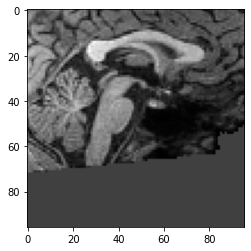

In [120]:
plt.imshow(np.rot90(dls.train_ds[idx][0][0,mid0]), cmap=plt.cm.gray)

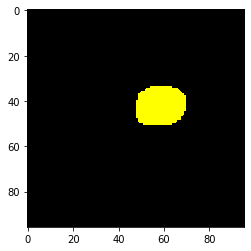

In [153]:
from matplotlib import colors
bin_cmap2  = colors.ListedColormap(['black', 'yellow'])

plt.imshow(np.rot90(pred_masks[idx][mid0]), cmap=bin_cmap2)

In [160]:
dls.train_ds[idx][0].shape

torch.Size([1, 96, 96, 96])

In [184]:
pred_bboxs[idx].shape

torch.Size([6])

In [199]:
from helpers.general import *
from helpers.preprocess import *

In [200]:
get_bbox_vals??

In [201]:
def twod_get_bbox(masks):
    # HW -> H
    # HW -> W
    j = torch.any(masks, dim=0) # 0 -> 1,2 -> 2 -> 1 left
    i = torch.any(masks, dim=1) # 1 -> 0,2 -> 0 -> 0 left

    imin, imax = torch.where(i)[0][[0, -1]]
    jmin, jmax = torch.where(j)[0][[0, -1]]
  
    return imin,imax,jmin,jmax

In [203]:
a,b,c,d = np.asarray(twod_get_bbox(sg))
print(a,b,c,d)

48 69 45 61


48 69 45 61
im (96, 96) sg (96, 96) (96, 96) (21, 16)


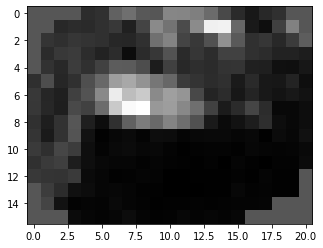

In [215]:
im = dls.train_ds[idx][0][0,mid0]
sg = pred_masks[idx][mid0]


a,b,c,d = np.asarray(twod_get_bbox(sg))
print(a,b,c,d)

im = np.asarray(im)
sg = np.asarray(sg)
m = np.multiply(im,sg)
print("im", im.shape, "sg", sg.shape, (im*sg).shape, np.multiply(im,sg)[a:b,c:d].shape)
#plt.imshow(np.rot90(im*sg),cmap=plt.cm.gray)


from torch import Tensor

def bbox_crop(im, bbox, axis_idx=None, margin=20):
    
    a,b,c,d,e,f = bbox
    
    # margin
    a -= margin; c -= margin; e -= margin
    b += margin; d += margin; f += margin
    
    
    if axis_idx is None:
        return im[a:b, c:d, e:f]
    
    elif axis_idx == 0:
        return im[c:d, e:f]
    
    elif axis_idx == 1:
        return im[a:b, e:f]
    
    elif axis_idx == 2:
        return im[a:b, c:d]
    
    else:
        return None
    

plt.imshow(np.rot90(m[a:b,c:d]), cmap=plt.cm.gray)


Resampled by a factor of 2 with cubic interpolation:


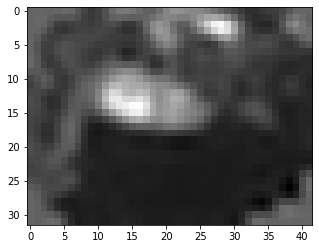

In [222]:
import numpy as np
import scipy.ndimage

x = m[a:b,c:d]
print('Resampled by a factor of 2 with cubic interpolation:')
plt.imshow(np.rot90(scipy.ndimage.zoom(x, 2, order=5)), cmap=plt.cm.gray)

In [223]:
x.shape

(21, 16)

In [224]:
# import cv2
# res = cv2.resize(img, dsize=(42,32), interpolation=cv2.INTER_CUBIC)

ModuleNotFoundError: No module named 'cv2'

In [197]:
batch_get_bbox??

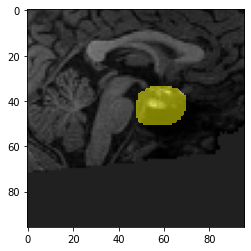

In [189]:
plt.imshow(np.rot90(im),cmap=plt.cm.gray)
plt.imshow(np.rot90(sg),cmap=bin_cmap2, alpha=0.5)

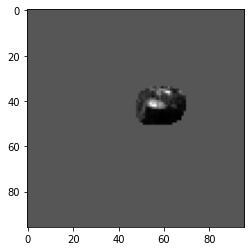

In [177]:
plt.imshow(np.rot90(im*sg), cmap=plt.cm.gray)

In [154]:
plt.imshow(np.rot90(dls.train_ds[idx][0][0,mid0][pred_masks[idx][mid0]]), cmap=bin_cmap2)

ValueError: Axes must be different.

In [ ]:
from matplotlib import colors

prob_cmap  = "GnBu" #"hot" https://matplotlib.org/stable/tutorials/colors/colormaps.html 
bin_cmap1  = colors.ListedColormap(['white', 'yellow'])
bin_cmap2  = colors.ListedColormap(['white', 'red'])

for idx in sorted_dice_idxs[:10]:

    print(f"Worst idx: {idx}. mr: {items[idx][0][len(data_src)+1:]}")
    
    gt_bbox   = gt_bboxs[idx]
    pred_bbox = pred_bboxs[idx]
    
    gt_map    = targets[idx].squeeze()
    prob_map  = probs[idx]
    pred_mask = pred_masks[idx]

    # max difference
    d = torch.abs(gt_map-prob_map)

    # along axis 0,1,2
    a0 = torch.sum(torch.sum(d, dim=2), dim=1)
    a1 = torch.sum(torch.sum(d, dim=2), dim=0)
    a2 = torch.sum(torch.sum(d, dim=1), dim=0)
    a0max, a0_idx = torch.max(a0), torch.argmax(a0)
    a1max, a1_idx = torch.max(a1), torch.argmax(a1)
    a2max, a2_idx = torch.max(a2), torch.argmax(a2)
    
    # plot
    fig, axes = plt.subplots(3,4, figsize=(12,12))
    for i in range(3):
        max_diff_idx = [a0_idx, a1_idx, a2_idx][i]
        
        gt_slice, prob_slice, pred_slice = [np.take(np.asarray(m), max_diff_idx, axis=i) for m in (gt_map, prob_map, pred_mask)]
        
        axes[i,0].imshow(gt_slice,   cmap=bin_cmap1)
        axes[i,0].imshow(pred_slice, cmap=bin_cmap2, alpha=0.5)
        axes[i,1].imshow(gt_slice,   cmap=bin_cmap1)
        im  = axes[i,2].imshow(prob_slice, cmap=prob_cmap, interpolation='nearest')  
        im2 = axes[i,3].imshow(np.log(prob_slice), cmap=prob_cmap, interpolation='nearest')  

        axes[i,0].set_title(f"Slice {max_diff_idx} (Axis {i})")
        axes[i,1].set_title(f"GT map")
        axes[i,2].set_title(f"Prob map")
        axes[i,3].set_title(f"Log Prob map")
        
        # colorbar
        fig.colorbar(im,  ax=axes[i,2])
        fig.colorbar(im2, ax=axes[i,3])

    plt.show()

In [90]:
# start = time.time()

# indiv_dices1 = dice_loss(predictions.argmax(1).unsqueeze(1), targets)
# elapsed = time.time() - start

# print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

In [88]:
indiv_dices1[0]

tensor([0.1962])

In [89]:
[1-dice_loss for dice_loss in indiv_dices1]

[tensor([0.8038]),
 tensor([0.8556]),
 tensor([0.7979]),
 tensor([0.7150]),
 tensor([0.8311]),
 tensor([0.8372]),
 tensor([0.8614]),
 tensor([0.7667]),
 tensor([0.8658]),
 tensor([0.8600]),
 tensor([0.7912]),
 tensor([0.8048]),
 tensor([0.7750]),
 tensor([0.8717]),
 tensor([0.8512]),
 tensor([0.8260]),
 tensor([0.8199]),
 tensor([0.7591]),
 tensor([0.7648]),
 tensor([0.7663])]

In [68]:
start = time.time()

indiv_dices2 = [dice_score(predictions[i].unsqueeze(0), targets[i].unsqueeze(0)) for i in range(len(targets))]
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

Elapsed: 2.68 s for 20 items.


In [69]:
indiv_dices

[tensor(0.8038),
 tensor(0.8556),
 tensor(0.7979),
 tensor(0.7150),
 tensor(0.8311),
 tensor(0.8372),
 tensor(0.8614),
 tensor(0.7667),
 tensor(0.8658),
 tensor(0.8600),
 tensor(0.7912),
 tensor(0.8048),
 tensor(0.7750),
 tensor(0.8717),
 tensor(0.8512),
 tensor(0.8260),
 tensor(0.8199),
 tensor(0.7591),
 tensor(0.7648),
 tensor(0.7663)]

In [26]:
start = time.time()

# sort dices from low to high
sorted_dice_idxs  = sorted(range(len(indiv_dices)), key=lambda i:indiv_dices[i].item()) 
np_indiv_dices = np.array([indiv_dices[i].item() for i in sorted_dice_idxs])

# plot
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0.hist(np_indiv_dices, bins="auto")
ax1.boxplot(np_indiv_dices)

fig1.suptitle("Dice Score (ABIDE test set + Cross label items)")
plt.show()

# time
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

TypeError: len() of a 0-d tensor

In [16]:
# # get all ensemble - Elapsed: 590.97 s. => 600 => 10min; Elapsed: 1171.70 s.
# start = time.time()

# for i in range(len(batches)):
#     # load each models pred (6) for (0,5), (5,10) etc => 30 preds per range
#     model_preds_dict = {model_fn:load_model_preds(model_fn, file_range=range(i,i+1)) 
#                         for model_fn in models_to_ensemble}
    
#     # get lcc for each of preds
#     dice_majority_votes = []
#     bce_majority_votes  = []
#     all_majority_votes  = []
                                   
#     for bs_item in range(len(batches[i])):
#         ordered_preds = [model_preds_dict[model_fn] for model_fn in models_to_ensemble]
#         all_preds = [(model_fn, get_largest_connected_component(torch2sitk(preds[bs_item].argmax(0).byte()))) 
#                      for model_fn, preds in zip(models_to_ensemble, ordered_preds)]
    
#         dice_preds = [preds for model_fn, preds in all_preds if "DICE_loss" in model_fn]
#         bce_preds  = [preds for model_fn, preds in all_preds if "BCE_loss" in model_fn]
#         all_preds  = [preds for model_fn, preds in all_preds]
        
#         # get majority vote
#         labelForUndecidedPixels = 0
#         dice_majority_vote = sitk.LabelVoting(dice_preds, labelForUndecidedPixels)
#         bce_majority_vote  = sitk.LabelVoting(bce_preds, labelForUndecidedPixels)
#         all_majority_vote  = sitk.LabelVoting(all_preds, labelForUndecidedPixels)

#         #print(majority_vote.GetSize())
#         dice_majority_votes.append(sitk2torch(dice_majority_vote))
#         bce_majority_votes.append(sitk2torch(bce_majority_vote))
#         all_majority_votes.append(sitk2torch(all_majority_vote))
    
#     # save model outputs
#     with open(f"{ensemble_src}/dice_preds_batch_{i}_bs_{bs}.pkl", 'wb') as handle:
#         pickle.dump(dice_majority_votes, handle)
        
#     with open(f"{ensemble_src}/bce_preds_batch_{i}_bs_{bs}.pkl", 'wb') as handle:
#         pickle.dump(bce_majority_votes, handle)
        
#     with open(f"{ensemble_src}/all_preds_batch_{i}_bs_{bs}.pkl", 'wb') as handle:
#         pickle.dump(all_majority_votes, handle)
        
#     print(len(all_majority_votes))
        
# elapsed = time.time() - start
# print(f"Elapsed: {elapsed:0.2f} s.")